In [1]:
from levee_hunter.dataset_images_choice import interactive_dataset_creation
from levee_hunter.utils import find_splits

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(


## Table of Contents
- [1. Introduction](#1-introduction)
- [2. Data Directory Dtructure](#2-data-directory-structure)
- [3. Creating a Database](#3-creating-a-database)
- [4. Creating Datasets](#4-creating-datasets)
- [5. Example](#5-example)
- [6. Additional Notes](#6-additional-notes)



# 1. Introduction
This notebook explains how datasets can be currently created and how to add more images to them.

#### Relevant Definitions:
1. **Database (DB)**: DB contains information about the original .tif files. Its main purpose is to hold information which .tif files have already been used and for what. 
It is essentially a table with 3 columns: file_id, file_name, state. 

    ***file_id*** - 10 characters generated based on file_name, should be unique to file_name \
    ***file_name*** - simple name of the .tif file, for example: `USGS_1M_15_x36y434_MO_FEMANRCS_2020_D20.tif` \
    ***state*** - represents whether the file has been used and for what, can be : unused, train_test, validation \ 

2. **Dataset (DS)**: DS is a SegmentationDataset instance which holds images and targets that can be used for model training or validating. It contains a split_and_pad method which is responsible for dividing the original .tif images into smaller ones (eg. 512 x 512), and then stores those smaller images.

3. **Resolution**: Refers to the Lidar image resolution, in our case we consider 1m or 13 (standing for 1 meter or 1/3 arcsec).

4. **Image Size**: Whenever image size is mentioned, it is meant to be measured in pixels. In our case we will usually have original images in .tif files, with larger size, which are then splitted into smaller ones.

# 2. Data Directory Structure

There are 4 directories inside the main data directory:

1. **files_db**: contains create_.py and any databases created using it which will be named {resolution}_{size}.db
2. **raw**: contains the raw .tif files, the original images. They are split into two subdirectories, dependning on resolution.
3. **intermediate**: contains datasets after they are created, it is split into subdirectories {resolution}_{size}, each of those subdirectories will contain create datasets bad.pth, train_test.pth and validation.pth once created.
4. **processed** original intent was to hold datasets already split into training and testing in there, but there is no need for that so for now it has no uses.

The base structure user should start with is simply:
<pre>
data
 ├─ files_db
 │   └─ create_db.py
 ├─ raw
 │   ├─ 1m_resolution
 │   │   ├─ file1.tif
 │   │   └─ file2.tif
 │   └─ 13_resolution
 │       ├─ fileA.tif
 │       └─ fileB.tif
 ├─ intermediate
 └─ processed
</pre>

The directory structure after creating some databases and datasets might look for example like this:
<pre>
data
 ├─ files_db
 │   ├─ 1m_512.db
 │   ├─ 1m_2016.db
 │   ├─ 13_512.db
 │   └─ create_db.py
 ├─ raw
 │   ├─ 1m_resolution
 │   │   ├─ file1.tif
 │   │   └─ file2.tif
 │   └─ 13_resolution
 │       ├─ fileA.tif
 │       └─ fileB.tif
 ├─ intermediate
 │   ├─ 1m_512
 │   │   ├─ bad.pth
 │   │   ├─ train_test.pth
 │   │   └─ validation.pth
 │   ├─ 1m_2016
 │   └─ 13_512
 └─ processed
</pre>

# 3. Creating a Database

Remember: the DB only holds information about .tif files, not the .tif files themselves, so it should not be large. \

#### Explanation:
1. For every resolution, desired image size pair, there should be a separate database. For example if user uses given .tif file when creating training images for 1m, (512, 512), it does not mean those images were used for 13, (256, 256), so the databases need to be separate for different combinations of resolution, size.

2. For given resolution, size, there should be a single DB for all users, their desired location is `/share/gpu5/pmucha/fathom/levee-hunter/data/files_db`.

3. **create_db.py**: This is the main script for creating databases. 

#### Process:

1. Activate your environment and run the script with: `python create_db.py`

2. Choose desired resolution

3. Choose desired smaller images size (after splitting the larger ones). Note: images are not split here, this is simply for naming convention.

4. If database for given (resolution, size) already exists inside /your_project_roow/data/files_db, sript will let user know about this and the user can decide to either delete it (and then replace with new one) or quit the script.

5. Script looks for .tif files at /your_project_root/data/raw/{resolution}_resolution (eg 1m_resolution). It lets user know how many files have been found and where, the asks user if they wish to continue.

6. When user accepts, script will create a new DB at /your_project_root/data/files_db/{resolution}_{size}.db, automatically creating parent directories if needed. All the .tif file_names added to te DB are given their unique file_id and their status is set to 'unused'.

7. Since we want single database for all the users to use, the script will check if this new DB has been saved to the target path which is `/share/gpu5/pmucha/fathom/levee-hunter/data/files_db`. If not, it will ask user if they want to copy this DB to the target path. 

8. If such DB already exists at the target path, the script will let user know and ask if they want to proceed. Since this would delete previous DB at the target path and replace it with new one, user needs to be sure they want to do that. Script will ask for a password which is just set to 1234, this is just to make sure user pays attention and does not type yes accidentally.


#### Example:

Below is an example of terminal after the python create_db.py, for the case of resolution = 1m, size = 512. \
**Note**: I changed the target directory inside create_db.py to be /share/gpu5/pmucha/fathom/levee-hunter/data/files_db2 (added 2 at the end), to demonstrate how code asks user to copy the DB. I immediatelly changed it back after this.

```

-> Please enter the desired resolution (1m or 13)1m  
-> Please enter the desired size of target smaller images (e.g. 256, 512)512 
-> Found 14 .tif files in /share/gpu5/pmucha/fathom/levee-hunter/data/raw/1m_resolution  

-> Do you wish to continue? (yes/no): yes 
-> Database created at /share/gpu5/pmucha/fathom/levee-hunter/data/files_db/1m_512.db  

File USGS_1M_15_x36y434_MO_FEMANRCS_2020_D20.tif added successfully with state 'unused'. 
File USGS_1M_15_x37y434_MO_FEMANRCS_2020_D20.tif added successfully with state 'unused'. 
... 
File USGS_one_meter_x63y424_CA_Sacramento_2017.tif added successfully with state 'unused'. 
-> Added 14 files to the database.  

-> Database creation completed. 
-> Database is currently at /share/gpu5/pmucha/fathom/levee-hunter/data/files_db, which is different from the target directory (/share/gpu5/pmucha/fathom/levee-hunter/data/files_db2). Do you want to copy it to there? (yes/no): yes 
-> Database copied and moved to /share/gpu5/pmucha/fathom/levee-hunter/data/files_db2/1m_512.db 
```


# 4. Creating Datasets

1. **interactive_dataset_creation**: This is the main function that handles image choice.

2. **Role**: Its main role is to allow users to create reliable datasets manually in an efficient and consistent way. 

3. **Datasets**: User will be creating 3 datasets: bad.pth, train_test.pth and validation.pth (see section 2).

4. **train_test.pth**: This is the dataset that can be used for training. The idea is to split it later into train/test datasets both of which are used during training (test dataset only to look for overfitting).

5. **validation.pth**: This is the main validation dataset, to fairly assess how model is doing. The idea is that this should be completely separate from the train_test. If for example given levee spans across 10 images, it would not be fair to use 8 of them for training and 2 for testing. Hence the idea behind this validation dataset is that it should be from a different area (different .tif files) than the train_test.

6. **bad.pth**: This dataset will contain (images, targets) which user rejected for any reason, for example because they had significantly missing levees on the mask.


#### interactive_dataset_creation process:
1. **Connect to DB**: First the interactive_dataset_creation function will connect to the chosen database. At the same time the database is locked so that no other process can modify it. Other users can still access it to extract information, but they cannot modify it while interactive_dataset_creation ir being run.

2. **Script Start**: Script will then check how many files have status 'unused' in this DB. 

3. **Process one .tif at a time**: Then we start with the first one of the 'unused' .tif files. We will always process a single .tif at a time. 

4. **Output Information**: For given .tif script should let user know how many .tif files we have left to process, what is the current file name (see known issues section in 5. Additional Notes) and what is its file_id. For example:

```
Starting interactive dataset creation...
Processing file 1/14
File ID: 0b705d501b
Filename: USGS_1M_15_x36y434_MO_FEMANRCS_2020_D20.tif
```

5. **Choose between train_test, validation or quit**: User can then choose if the current .tif will contribute to the train_test.pth, or validation.pth.
This choice will be reflected in the DB, and user will be informed of this:
```
File 0b705d501b successfully moved to 'train_test'.
Splitting file, please wait..
```
6. **Preparing Masks and Splitting Image**: The original .tif file is then used together with the full levee data to obtain mask and then to split this according to the inputs. 

7. **Select Images**: After original large image is split, user will be shown smaller images with their masks, one pair at a time. User is informed how many smaller images are left inside current .tif:
```
Processing part 1/16
```

8. **Keep (a)**: To keep an image, user can either type 'keep' or just 'a', the letters I chose are just convenient to press on keyboard (a, w, d, q). Keep will simply include the current image in either train_test or validation dataset, depending on which option user chose for the current .tif.

9. **Special (w)**: Has the same effect as Keep, but this image will have higher weight in the dataset.

10. **Remove (d)**: This image will be added to the bad.pth dataset. 

11. **Save Dataset**: When all images from current .tif have been processed, script automatically checks if dataset already exists, if no, it saves the datasets bad.pth and train_test.pth or validation.pth depending on what user selected for the current .tif. If corresponding dataset already exists, it is simply expanded by adding new images from the current .tif.

12. **Proceed to next .tif and repeat steps 4 - 12, untill no .tif files are left in the DB**

13. **Quit at any time**: The quit option (q) is available at all times, the script is made such that it can be safely pressed at any time to finish. When (q) is pressed before selecting (t, v, q) for next .tif, script will simply finish. Since the datasets are saved every time when we move to the next .tif, they would already be saved and since we are before (t, v, q) choice, current .tif has not been moved in the database.

    If (q) is pressed during image selection, current .tif will simply be moved back to 'unused' and all the currently selected images are discarded and script finishes.

    Every time (q) is pressed, connection to the DB is closed and the DB is unlocked so that it can be modified again. User is informed of this with:
```
Releasing database lock...
```

14. **Unlocking Database** The script is written such that the DB should be unlocked once (q) is selected or when something like a kernel crash / restart happens, although the safest option is always to select (q). If the DB remains locked for any reason when it shouldn't be, user can try to unlock it manually or just finish current process and it might be unlocked by itself (close VS Code for example).


#### Note: 
target masks created this way contain single pixel thick levees, during image choice they are plotted thicker, but in the dataset they are actually single pixel thick. The dilation_s parameter controls this only for plotting. This allows the masks to be general, and user can then apply any changes they wish to them, for example make those lines thicker. In the future, this will be implemented using SegmentationDataset.__apply_mask_type.

# 5. Example

I have ran the create_db.py for resolution 1m and size 2016. Such large and unusual shape I chose just for this tutorial, to make image selection quick. This is probably not gonna be useful for the actual training and therefore anyone can make any changes they wish to the 1m_2016.db and datasets inside 1m_2016.

### Choosing Overlap

At this stage, user will need to decide on the overlap applied during splitting the original image into smaller ones, the function below is used to recommend possible overlaps, this function is discussed more in the Tutorial.ipynb.

In [2]:
# Choose overlap, we will choose the top option as it allows to cover 
# The entire image in this case
find_splits(10012, 2016, max_overlap_frac=0.1)[:6]

n, overlap, total_covered


[(5, 17, 10012),
 (5, 18, 10008),
 (5, 19, 10004),
 (5, 20, 10000),
 (5, 21, 9996),
 (5, 22, 9992)]

In [3]:
interactive_dataset_creation(
    db_path='../data/files_db/1m_2016.db',
    levees_file_path="../data/raw/w3-Levees/levees.gpkg",
    resolution="1m",
    size=2016,
    overlap=17,
    dilation_s=11,
)

Processing file 8/14
File ID: 8e1bd80813
Filename: USGS_1M_15_x55y347_LA_Sabine_River_Lidar_2018_D18.tif
Releasing database lock...


SystemExit: 0

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# We can now load the dataset, this can be done after processing the first .tif.

import torch
from levee_hunter.segmentation_dataset import SegmentationDataset

dts = torch.load('../data/intermediate/1m_2016/validation.pth', weights_only=False)

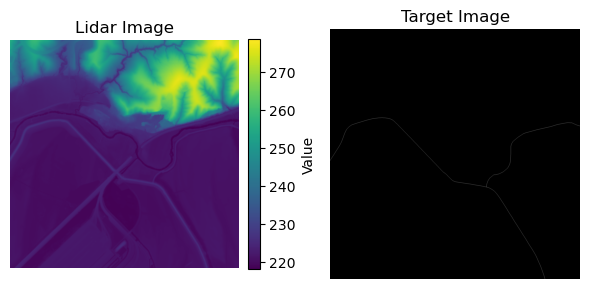

In [5]:
# The dilation_size is used for plotting only, set to 1 shows the original mask
dts.plot(0, dilation_size=1)

# 6. Additional Notes

1. **Locked DB**: As mentioned before, it should not be easy to permamently lock the database, but if it is accidentally locked or deleted, in the worst case scenario, uniqueness of file_id will allow to recover all the information from the train_test.pth and validation.pth.

2. **Targets created in this process are Single Pixel thick**, user can then apply thickening or gaussian or process them in other way.

3. **Database Management**: DB is created using SQLite, there are useful function to access information and modify a DB inside the levee_hunter.database_management. The functions in there are safe, in a sence that they would not cause weird behaviour on a locked database. If one wishes to add new function which modifies (not just accesses information from) a database, the following block should be used to make the function safe:
```
    except sqlite3.OperationalError as e:
        if "database is locked" in str(e):
            print(f"Database is locked. Rolling back state change for {identifier}.")
            conn.rollback()  # Undo the transaction if locked
            return None  # Return None to indicate failure
        else:
            raise  # Raise any other errors
```

4. **Known issuses**: Sometimes (rarely) during the [train_test / validation / quit] choice, name of the current file regarding which user is making a decision is not being shown. I wasn't sure what was causing the issue and tried to apply a simple time.pause fix, but I am not 100% sure if this will be now avoided. This is just output issue, the actual process works fine, this issue is just with the output not being cleared at the right moment, it is displayed correctly after (t / v / q) choice however.

    If knowing the name of current file is important to the user, it might be best to output them before starting the interactive_dataset_creation, as shown in cell below:

In [6]:
from levee_hunter.database_management import get_files_by_state
import sqlite3

db_path='../data/files_db/1m_2016.db'
conn = sqlite3.connect(db_path)
get_files_by_state(conn, state='unused')

[('8e1bd80813', 'USGS_1M_15_x55y347_LA_Sabine_River_Lidar_2018_D18.tif'),
 ('be47257a41', 'USGS_1m_x62y428_CA_NoCAL_Wildfires_B5a_2018.tif'),
 ('72c70224ce', 'USGS_1m_x62y432_CA_NoCAL_Wildfires_B5a_2018.tif'),
 ('9e050c77a1', 'USGS_1m_x63y427_CA_NoCAL_Wildfires_B5a_2018.tif'),
 ('f30216fb50', 'USGS_one_meter_x61y424_CA_Sacramento_2017.tif'),
 ('9f1fdbbcbe', 'USGS_one_meter_x63y423_CA_Sacramento_2017.tif'),
 ('9d004d9b74', 'USGS_one_meter_x63y424_CA_Sacramento_2017.tif')]